In [1]:
import cv2
import numpy as np
import nbimporter
import util

Importing Jupyter notebook from util.ipynb


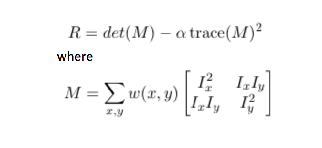

In [6]:
'''
ref: http://aishack.in/tutorials/harris-corner-detector/

'''

img = util.read_img('harris_value.png')
util.show_img(img, size=(5,5))

In [3]:
def harris_values(img, window_size=5, harris_scoring=0.04, norm=False):
    # calculate image gradients on x and y dimensions
    Ix = util.grad_x(img, 3)
    Iy = util.grad_y(img, 3)
    Ixx = Ix ** 2
    Ixy = Ix * Iy
    Iyx = Iy * Ix
    Iyy = Iy ** 2
    
    # create the weight window matrix
    c = np.zeros((window_size, window_size), dtype=np.float32);
    c[window_size // 2, window_size // 2] = 1.0
    w = cv2.GaussianBlur(c, (window_size, window_size), 0)
    Rs = np.zeros(img.shape, dtype=np.float32)
    
    rows, cols = img.shape
    for r in range(rows - window_size + 1):
        rmax = r + window_size
        for c in range(cols - window_size + 1):
            cmax = c + window_size
            I = [Ixx[r:rmax, c:cmax], Ixy[r:rmax, c:cmax], Iyx[r:rmax, c:cmax], Iyy[r:rmax, c:cmax]]
            M = [np.sum(wI) for wI in w * I]
            M = np.array(M).reshape((2,2))
            Rs[r,c] = np.linalg.det(M) - harris_scoring * (M.trace() ** 2)
    if norm:
        Rs = cv2.normalize(Rs, Rs, alpha=0, beta=255,
                           norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return Rs


In [4]:
def harris_corners(img, window_size=5, harris_scoring=0.04, threshold=1e-2, nms_size=10):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # calculate harris values for all valid pixels
    Rs = harris_values(img, window_size, harris_scoring)
    # apply thresholding, i.e keep values in Rs which satisy following conditions and all other elements to 0
    Rs = Rs * (Rs > (threshold * Rs.max())) * (Rs > 0)
    # apply non maximal suppression
    rows, columns = np.nonzero(Rs)
    new_Rs = np.zeros(Rs.shape)
    for r,c in zip(rows, columns):
        minr = max(0, r - nms_size // 2)
        maxr = min(img.shape[0], minr + nms_size)
        minc = max(0, c - nms_size // 2)
        maxc = min(img.shape[1], minc + nms_size)
        if Rs[r,c] == Rs[minr:maxr,minc:maxc].max():
            new_Rs[r,c] = Rs[r,c]
    return new_Rs